### Test case LVV-T1862: Verify determining effectiveness of dark current frame

Verify that the DMS can determine the effectiveness of a dark correction and determine how often it should be updated.

**Discussion:** To demonstrate the effectiveness of the dark corrections, we will examine a combined dark image from ComCam data. This notebook begins with the dark calibration objects that have already been created during ComCam on-sky data processing.

In [1]:
import matplotlib.pyplot as plt
import lsst.afw.display as afwDisplay
from lsst.daf.butler import Butler
from lsst.ip.isr.isrFunctions import darkCorrection

Initialize the butler, and define the collection (corresponding to w_2025_10 processing) we will use.

In [2]:
INSTRUMENT = "LSSTComCam"
COLLECTION = "LSSTComCam/runs/DRP/DP1/w_2025_10/DM-49359"
butler = Butler("/repo/main")

Query the butler for `postISRCCD` images, then select a single dataId and retrieve the image and its associated dark object.

In [3]:
query = butler.query_datasets('postISRCCD', collections=COLLECTION)

In [4]:
# Select an image and its dark object:
postisrccd = butler.get(query[1])
dark = butler.get("dark", collections=COLLECTION, dataId=query[1].dataId)

Make a copy of the image so we can test applying the crosstalk correction to it:

In [5]:
postisrccd_copy = postisrccd.clone()

#### Apply the "darkCorrection" task from `lsst.ip.isr`

Apply the task to the copy of the `postISRCCD` image, then compare the resulting image to the original (by taking the ratio of the two).

In [6]:
# darkCorrection takes an input image, dark image, exposure time of the input image,
#   and exposure time of the dark frame. It operates on the input image in place.

darkCorrection(postisrccd_copy.image, dark.image, postisrccd_copy.visitInfo.darkTime, dark.visitInfo.darkTime)

In [7]:
afwDisplay.setDefaultBackend('matplotlib')

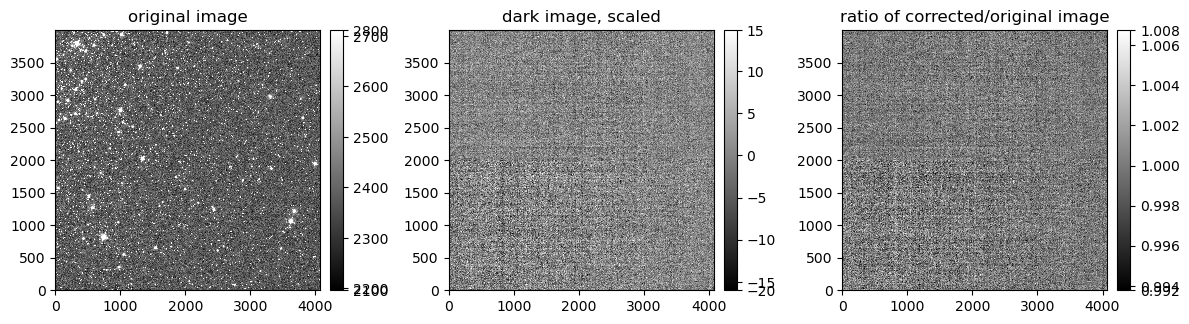

In [9]:
ratio = postisrccd_copy.clone()
ratio.image /= postisrccd.image

dark_scaled = dark.clone()
dark_scaled.image *= postisrccd.visitInfo.darkTime/dark.visitInfo.darkTime

fig, ax = plt.subplots(figsize=(12, 8), nrows=1, ncols=3)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
display0.mtv(postisrccd.image)
plt.title('original image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(dark_scaled.image)
plt.title('dark image, scaled')

plt.sca(ax[2])
display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
display2.mtv(ratio.image)
plt.title('ratio of corrected/original image')

plt.tight_layout()
plt.show()

The ratio of the corrected and original images (on the right) varies by roughly +/-0.8%, confirming that the dark correction was successful applied. The scaled dark frame in the central panel is a well-formed image of the same dimensions as the `postISRCCD` image.

#### Examine the dark image's metadata

In [10]:
dark.metadata

CALIB_CREATION_DATETIME = "2025-02-08T21:18:50"
// UTC of processing
CALIB_CREATION_DATE = "2025-02-08"
// Local time day of creation
CALIB_CREATION_TIME = "13:18:50 PST"
// Local time in day of creation
BINX = 1
// [pixels] binning along X axis
BINY = 1
// [pixels] binning along Y axis
CCDGAIN = 1.0000000000000
// Rough guess at overall system gain (e-/DNB)
CCDNOISE = 10.000000000000
// Rough guess at system noise (e- rms)
DETSIZE = "[1:4072,1:4000]"
IMGTYPE = "DARK"
// BIAS, DARK, FE55, FLAT, FLAT_<lam>, SPOT, PPUMP
BUNIT = "adu"
// Brightness units for pixel array
INSTRUME = "ComCam"
// Instrument
TELESCOP = "Simonyi Survey Telescope"
// Telescope
OBSGEO-X = 1818938.9400000
// [m] X-axis Geocentric coordinate
OBSGEO-Y = -5208470.9500000
// [m] Y-axis Geocentric coordinate
OBSGEO-Z = -3195172.0800000
// [m] Z-axis Geocentric coordinate
ROTCOORD = "sky"
// Telescope Rotation Coordinates
HASTART = 0.0000000000000
// [HH:MM:SS] Telescope hour angle at start
AMSTART = 0.0000000000000
// 

## Results

The metadata shows information about the dark frame, the number of inputs (43) and the scaling that was applied, as well as provenance (i.e., software versions, etc.) sufficient to recreate the dark image.

We see that the dark correction images have been created, and have demonstrated their application to an image. Given the demonstrated existence and effectiveness of the dark corrections, we deem this test's result a *Pass*.